# __3D TECHNOLOGIES__

__REPORT: On Reducing Maintenance Cost__


__Elaborated by: Sergio Nieto__

__Objective__

This document is a report on the work done by *The Data Science Team* building a predictive model using machine learning to predict the probability of a device failure. 

__Context__

The data is about a fleet of devices transmitting daily aggregated telemetry
attributes.

Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. 

This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

__Resume__

The report contains the process of model selection over a benchamark made of five models. The final model proposed to solve the failure detection problem is a __Gradient Boosting Machine__ trained on a 5-fold cross validated set. 

The paper also contains the line of work followed to create the solution and the evaluation of the following models: a Decision Tree Classifier, a Random Forest Classifier and a Gradient Boosting Classifier. We also include the construction of a semi-supervised learning ensemble: An Autoencoder-GBM.

Training metrics of all the models are given on an over-sampled set given by the method called SMOTE: Synthetic Minority Over-sampling Technique.

The Autoencoder was built with Keras and has the following structure:

1. Linear activation function to input layer
2. Hidden layer with 16 nodes, the same as the input layer
3. Linear activation function to hidden layer
4. Output layer with 8 nodes



In [1]:
# The libraries we'll use in this report are:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.lines as mlines
from IPython.core.pylabtools import figsize
import warnings
import pickle

# Processing
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_val_predict,cross_val_score,ShuffleSplit
from sklearn.feature_selection import SelectKBest, SelectFromModel
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import NearMiss
from sklearn.compose import ColumnTransformer
from sklearn.base import clone

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Representation Learning for the autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy

# Evaluation
from sklearn.metrics import roc_curve,auc, roc_auc_score,accuracy_score, recall_score, f1_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, balanced_accuracy_score,precision_score,average_precision_score, precision_recall_curve

plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set()

In [2]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')
print(f'pandas   {pd.__version__}')

sklearn    0.23.1
tensorflow 2.2.0
keras      2.3.0-tf
numpy      1.18.5
pandas   1.0.4


In [3]:
# 
tf.random.set_seed(2020)
np.random.seed(2020)

In [4]:
# We check that it is a csv file
# cat device_failure.csv | head 
# terminal command shows no problem
# since we know nothing about the file encoding, latin-1 will be used.

In [4]:
devices = pd.read_csv("device_failure.csv", encoding='Latin-1')

# Exploratory Data Analysis 

In [6]:
devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [7]:
# Number of different devices

devices.device.nunique()

1169

In [8]:
# How many different dates?

devices.date.nunique()

304

In [9]:
# Not all devices have the same number of records
# This may be a disadvantage for a time series approach to detecting failure

# we take to examples from the previous head:

devices[devices.device == "S1F01085"]["date"].nunique()

6

In [10]:
devices[devices.device == "S1F01E6Y"]["date"].nunique()

48

In [11]:
# Before proceeding, we look at the info in the data frame:

devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
# We have more than 100 thounsand records, but how many are failures?

devices.failure.value_counts(normalize=True)

0    0.999149
1    0.000851
Name: failure, dtype: float64

In [6]:
# Date are converted to datetime from pandas in case we need to use later on these functionality

devices["date"]=pd.to_datetime(devices["date"])

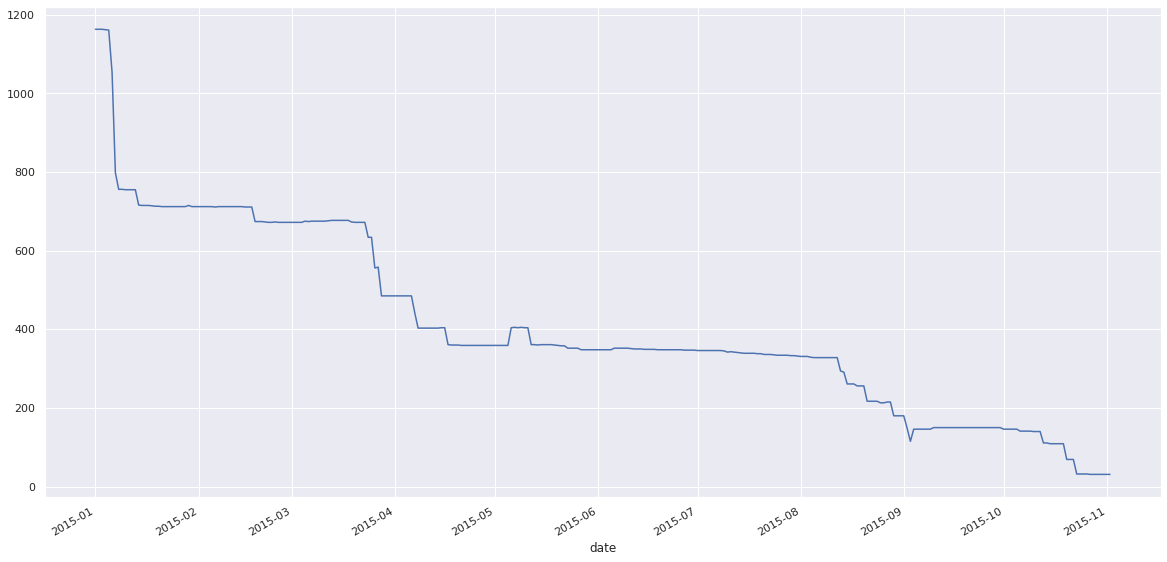

In [10]:
# Since we know

devices.groupby(["date"])["device"].nunique().plot()

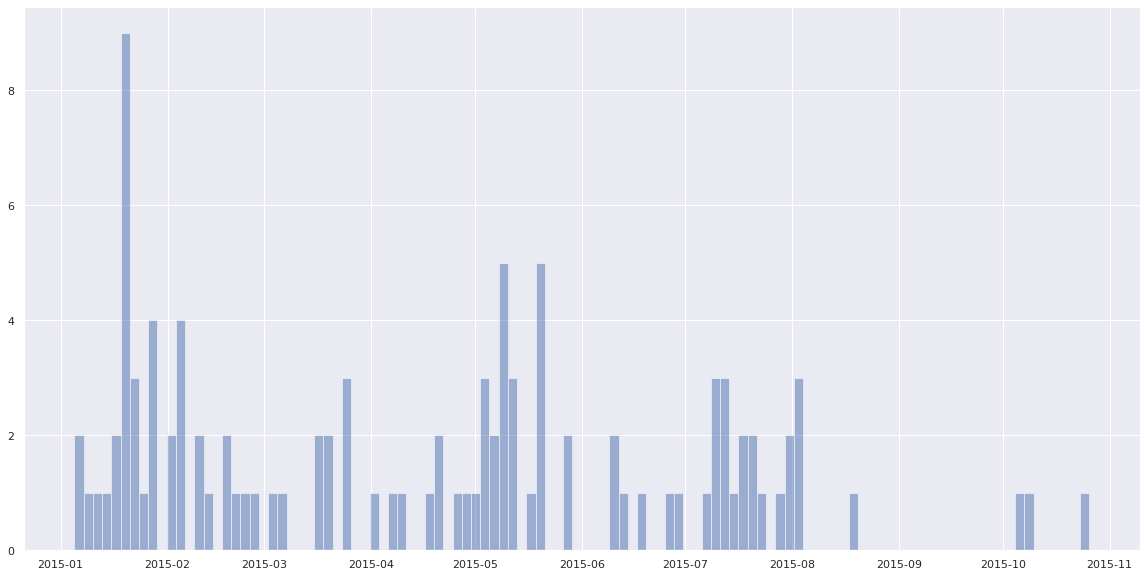

In [15]:
devices.query("(failure == 1)").date.hist(bins = 110, alpha = 0.5)

In [16]:
devices.groupby(["device"])["date"].count().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: date, dtype: float64

__Create a data frame based only on failures to understand better the structure of the time series__

In [17]:
list_failures=list(set(devices[devices.failure == 1]['device']))
devices.loc[devices.device.isin(list_failures),"tag"] = 1
devices.loc[~devices.device.isin(list_failures),"tag"] = 2

In [18]:
failures = devices[devices.tag == 1]
non_failures = devices[devices.tag == 2]

In [19]:
non_failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2.0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2.0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2.0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2.0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2.0


In [20]:
failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,1.0
23,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0,1.0
44,2015-01-01,S1F09DZQ,0,12568128,136,0,2,6,380112,0,0,2,1.0
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3,1.0
74,2015-01-01,S1F0DSTY,0,8471680,0,0,0,11,436682,0,0,0,1.0


In [21]:
failures.device.nunique()

106

In [22]:
failures.groupby("device").date.describe().reset_index().head()

,device,count,unique,top,freq,first,last
0,S1F023H2,19,19,2015-01-04,1,2015-01-01,2015-01-19
1,S1F03YZM,215,215,2015-07-19,1,2015-01-01,2015-08-03
2,S1F09DZQ,199,199,2015-01-31,1,2015-01-01,2015-07-18
3,S1F0CTDN,7,7,2015-01-04,1,2015-01-01,2015-01-07
4,S1F0DSTY,45,45,2015-02-01,1,2015-01-01,2015-02-14


In [23]:
failures_desc = failures.groupby("device").date.describe().reset_index()
failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
non_failures_desc = non_failures.groupby("device").date.describe().reset_index()
non_failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


In [24]:
failures_desc["first"].describe()

count                     106
unique                      1
top       2015-01-01 00:00:00
freq                      106
first     2015-01-01 00:00:00
last      2015-01-01 00:00:00
Name: first, dtype: object

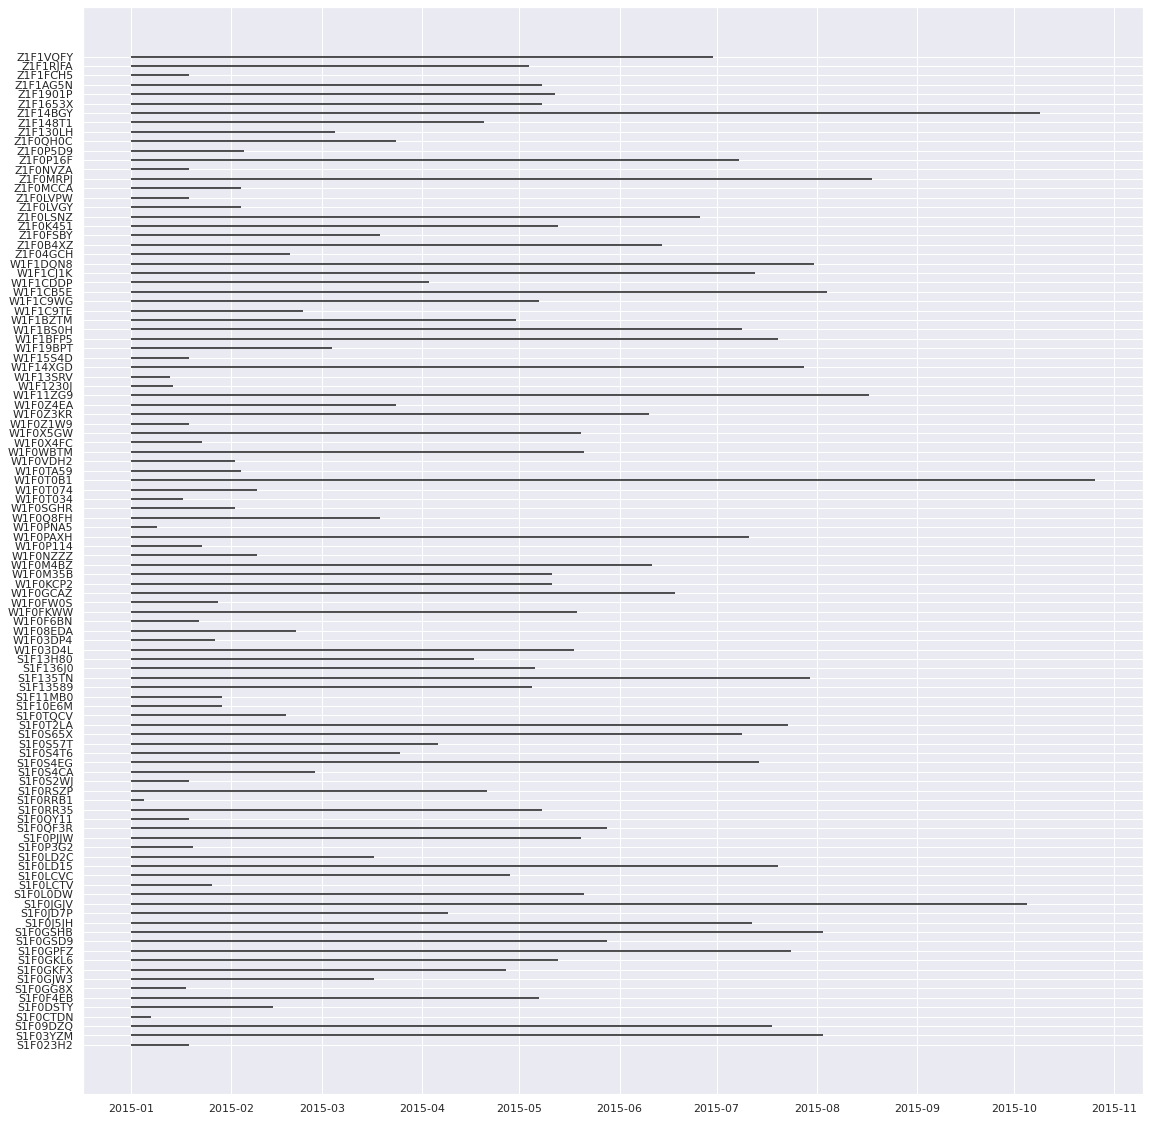

In [25]:
df = failures_desc.rename(columns={'device':'device',
                          'first':'Initial', # we have to change names since "first" is reserved
                          'last':'Final'})

fig = plt.figure(figsize=(19,20))
ax = fig.add_subplot(1,1,1)
ax = ax.xaxis_date()
ax = plt.hlines(df.device, dt.date2num(df.Initial), dt.date2num(df.Final))

In [26]:
failures[failures.device == "S1F0RRB1"]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1,1.0
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1,1.0
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1,1.0
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1,1.0
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1,1.0


We do not have a regular pattern over a date range, failures can happen at week 2 or any other week. We cannot take this problem with a time series perspective since it'll have the property that predictions will be based on a window with only a week maybe two as history and the need to drop observations.

As a first conclusion, we have to treat this problem as a supervised machine learning problem, in particular a binary classification task on the target variable 'failure'.

# Data Processing and Feature selection

In [7]:
process_cols = ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']

In [8]:
# A descriptive analysis will help to understand relation between variables
# 
devices[process_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [30]:
## It seems we have two very similar variables: attribute7 and attribute8

In [29]:
# We can also look at the correlation matrix between variables:

corr = devices[process_cols].corr() 
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000,-0.004,0.004,0.002,-0.003,-0.002,0.000,0.000,0.001
attribute2,-0.004,1.000,-0.003,0.147,-0.014,-0.026,0.141,0.141,-0.003
attribute3,0.004,-0.003,1.000,0.097,-0.007,0.009,-0.002,-0.002,0.532
attribute4,0.002,0.147,0.097,1.000,-0.010,0.025,0.046,0.046,0.036
attribute5,-0.003,-0.014,-0.007,-0.010,1.000,-0.017,-0.009,-0.009,0.006
attribute6,-0.002,-0.026,0.009,0.025,-0.017,1.000,-0.012,-0.012,0.021
attribute7,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute8,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute9,0.001,-0.003,0.532,0.036,0.006,0.021,0.007,0.007,1.000


We can see a very important issue here: attribute7 and attribute8 have correlation 1 and the same distribution. 

Most likely they are equal, but still no new information will be generated by keeping both variables.

In [9]:
devices.drop(columns=["attribute7"], axis=1, inplace=True)

# And we remove it also from the list of attributes for processing

process_cols.remove('attribute7')

In [10]:
# We can look now to linear correlation between variables and the target:

devices.corr()['failure'].sort_values(ascending=False)

failure       1.000000
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute6   -0.000550
attribute3   -0.000948
Name: failure, dtype: float64

__Feature Selection__

 Before we proceed to selection method, attributes need to be standarized since ranges differ from each other and this will cause truble with selection by logistic regression.

In [11]:
# We create two pipelines for processing data so that we have them available for later use:

# We reserve PCA pipeline if needed.

num_pipeline = Pipeline([
    ("estandarizador", StandardScaler())
])


pipeline = ColumnTransformer([
    ("cont", num_pipeline, process_cols)#,
    #("pcas", PCA(n_components = 1, random_state=2020), process_cols)
])

In [16]:
df_num = pipeline.fit_transform(devices)

In [17]:
std_cols = ['x1', 'x2', 'x3' , 'x4', 'x5', 'x6', 'x7' , 'x8']

In [18]:
df_num = pd.DataFrame(df_num, columns=std_cols)

In [19]:
df_num["y"] = devices["failure"]

In [20]:
df_num.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479,0
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047,0
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047,0
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047,0
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375,0


In [38]:
X = df_num[std_cols].values
Y = df_num.y

In [39]:
poly = PolynomialFeatures(interaction_only=True)
X_int = poly.fit_transform(X)

In [40]:
selector = SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                        max_iter=200,
                                                        random_state=2020), 
                           threshold = 'median').fit(X_int, Y)
selector.estimator_.coef_

array([[-0.49533753,  0.18914722,  1.24371904, -5.52573988,  0.84532227,
        -0.23263094,  0.28724526,  1.48718155, -1.41304512, -0.11276852,
         1.85475531, -0.28057735,  0.17412718, -0.01439656,  0.44078069,
         1.52082723, -0.29364314, -0.02108822,  0.97060255,  0.91767086,
        -0.41926479,  1.03249105, -3.81830848, -6.05914619,  4.65637122,
        -0.47385241, -0.50548736,  0.65569993, -0.77778383,  0.14528875,
        -3.29678448,  0.39791156,  0.45544156, -1.15487165,  0.18035603,
        -0.51614393, -0.13894346]])

In [41]:
selector.get_support()

array([False, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
       False])

In [42]:
selector.threshold_

0.5054873617015109

We have a second conclusion: by feature selection with a logistic regression, we can drop the nearly uniformly distributed variable: attribute1 and others that show almost no correlation to the target. 

This is only a way to select a *strategy*: first we'll try with all the variables and only drop the ones we detect here to get better performance.

A third conclusion is the need for *interactions*, these mean nonlinear relation between attributes to help predicting the target.  

A good direction to take this nonlinear relations into account is the use of tree-based algorithms.

So, now we can draw a strategy for modelling: we'll try tree-based algorithms as benchmarks and from there we can search for an optimal model. Since nonlinear relations seem to be in the play, we can also try neural network architecture to solve our classification task.

# Modelling: Benchmark

In [12]:
###################
# target variable
y = devices.failure
###################

# We separate in train and test sets to measure the performance and to test generalization capacity of the models.

X_train, X_test, y_train, y_test = train_test_split(devices[process_cols],y,
                                                    test_size=0.3, 
                                                    stratify= y, 
                                                    random_state=2020)

# For the a later case we use the standarization pipeline build before.
# We apply it separately to avoid data leakage

X_train_lg = pipeline.fit_transform(X_train)
X_test_lg = pipeline.fit_transform(X_test)

#################################################

 We are dealing with imbalanced classes (only 106 failures) it is a good practice to use a library to help over samplig.
 
 We can also try down-samplig.

 SMOTE is a technique used to help in the situation we have.

 SMOTE was proposed in 

 Bowyer, et al., 2002, SMOTE: Synthetic Minority Over-sampling Technique, 
 Journal of Artificial Intelligence Research 16 (2002) 321–357 
 (https://arxiv.org/pdf/1106.1813.pdf, accessed on July 2020).

In [13]:
sm = SMOTE(random_state = 2)

nr = NearMiss() 
# First, do the over-sampling for stadandarized sets:

X_train_rlg, y_train_rlg = sm.fit_sample(X_train_lg, y_train.ravel())

# We'll try tree based algorithms so we have no need for any scale transformation, but still have to balance the sets:

X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [14]:
y_train_rlg = pd.DataFrame(y_train_rlg, columns=['y'])
X_train_rlg = pd.DataFrame(X_train_rlg, columns=process_cols)
X_test_lg = pd.DataFrame(X_test_lg, columns=process_cols, index=X_test.index)
X_train_lg = pd.DataFrame(X_train_lg, columns=process_cols, index=X_train.index)
X_train_res = pd.DataFrame(X_train_res, columns=process_cols)
y_train_res = pd.DataFrame(y_train_rlg, columns=['y'])

## PROTOTYPES

The simplest prototypes we can try are decission trees. But we'll build also the popular ensembles: random forest and gradient boosting machines.


In [15]:
# To test these benchmarks we'll copy the devices data frame:
eval_devices = devices.copy()

# And weork with this to save results.

In [16]:
# Decission Tree Classifier

dtc = DecisionTreeClassifier(max_depth=8, criterion = 'entropy',
                                  max_features="auto", 
                                  class_weight="balanced", 
                                  min_samples_split = 10,
                                  #ccp_alpha= 0.0001,
                                  random_state=2020)

dtc = dtc.fit(X_train_res,y_train_res)

In [17]:
# Random Forest Classifier

rfc = RandomForestClassifier(n_estimators=260, 
        max_features='auto', max_depth= 8,
        bootstrap=True, ccp_alpha = 0.0001,
        oob_score=True, n_jobs=-1, random_state=2020, 
        class_weight='balanced')

rfc = rfc.fit(X_train_res,y_train_res)

In [18]:
# Gradient Boosting Classifier

gbc = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features=7, validation_fraction=0.1, 
                           n_estimators=250, n_iter_no_change=12,
                           random_state=2020, subsample=0.95)

# In the experiments done before constructing the report it's a good observation that there is no need for too many estimators.

gbc = gbc.fit(X_train_res, y_train_res)

In this step, we go to the usual evaluation on train and test sets. And present the classification report:

In [28]:
print('Accuracy DTC on train',dtc.score(X_train, y_train))
print('Accuracy DTC on test',dtc.score(X_test, y_test))

print('Accuracy RFC on train',rfc.score(X_train, y_train))
print('Accuracy RFC on test',rfc.score(X_test, y_test))


print('Accuracy GBC on train',gbc.score(X_train, y_train))
print('Accuracy GBC on test',gbc.score(X_test, y_test))

Accuracy DTC on train 0.9460439497389408
Accuracy DTC on test 0.9449516720661865
Accuracy RFC on train 0.9622927305066269
Accuracy RFC on test 0.9612573295135077
Accuracy GBC on train 0.9042056342876814
Accuracy GBC on test 0.9049238266084768


In [29]:
# In the following reports, the cutoff at 0.5 is used by default:

classes_dtc = dtc.predict(X_test)
print(classification_report(classes_dtc, y_test))

classes_rfc = rfc.predict(X_test)
print(classification_report(classes_rfc, y_test))

classes_gbc = gbc.predict(X_test)
print(classification_report(classes_gbc, y_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     35291
           1       0.53      0.01      0.02      2058

    accuracy                           0.94     37349
   macro avg       0.74      0.50      0.49     37349
weighted avg       0.92      0.94      0.92     37349

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35894
           1       0.62      0.01      0.03      1455

    accuracy                           0.96     37349
   macro avg       0.79      0.51      0.50     37349
weighted avg       0.95      0.96      0.94     37349

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     33778
           1       0.81      0.01      0.01      3571

    accuracy                           0.90     37349
   macro avg       0.86      0.50      0.48     37349
weighted avg       0.90      0.90      0.86     37349



Now we can put the labels and report what happens in the failure detection case:

In [19]:
eval_devices["predict_dtc"] = dtc.predict_proba(eval_devices[process_cols])[:,1]
eval_devices["predict_rfc"] = rfc.predict_proba(eval_devices[process_cols])[:,1] 
eval_devices["predict_gbc"] = gbc.predict_proba(eval_devices[process_cols])[:,1]

In [20]:
eval_devices.loc[:, 'label_dtc'] = 1 * (eval_devices.loc[:, 'predict_dtc'] > .6) 
eval_devices.loc[:, 'label_rfc'] = 1 * (eval_devices.loc[:, 'predict_rfc'] > .6) 
eval_devices.loc[:, 'label_gbc'] = 1 * (eval_devices.loc[:, 'predict_gbc'] > .6) 

In [21]:
eval_devices[eval_devices.failure==0].label_dtc.value_counts(normalize=False)

0    117928
1      6460
Name: label_dtc, dtype: int64

In [38]:
eval_devices[eval_devices.failure==0].label_rfc.value_counts(normalize=False)

0    121004
1      3384
Name: label_rfc, dtype: int64

In [37]:
eval_devices[eval_devices.failure==0].label_gbc.value_counts(normalize=False)

0    117318
1      7070
Name: label_gbc, dtype: int64

We save the prototypes for later use and comparison.

In [50]:
pickle.dump(dtc, open('dtc.pkl', 'wb'))

In [51]:
pickle.dump(rfc, open('rfc.pkl', 'wb'))

In [52]:
pickle.dump(gbc, open('gbc.pkl', 'wb'))

# TRAIN THE PROTOTYPES WITH CROSS-VALIDATION

The following step is to work with this prototypes to optimize an error function and with the help of the Precision-Recall curves do a better job at choosing the right model.

## DECISION TREE CLASSIFIER

In [30]:
dtc_k = DecisionTreeClassifier(max_depth=8, criterion = 'gini',
                                  max_features="auto", 
                                  class_weight="balanced", 
                                  #min_samples_split = 15,
                                  #ccp_alpha= 0.0001,
                                  random_state=2020)

In [31]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_res.index,
                                        columns=[0,1])

k_fold = StratifiedKFold(n_splits=6,shuffle=True,random_state=2020)

In [24]:
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 

In [36]:
def train_model(model):    
    # Initialize the accuracy of the models to blank list. The accuracy of each model will be appended to this list
    precision_model = []

    # Iterate over each train-test split
    for train_index, test_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    # Split train-test
        X_ktrain, X_ktest = X_train.iloc[train_index], X_train.iloc[test_index]
        y_ktrain, y_ktest = y_train.iloc[train_index], y_train.iloc[test_index]
        #SMOTE

        X_ktrain_res, y_ktrain_res = sm.fit_sample(X_ktrain, y_ktrain)
        # Under sampling

        X_uktrain_res, y_uktrain_res = nr.fit_sample(X_ktrain_res, y_ktrain_res)
        # Train the model
        model.fit(X_uktrain_res, y_uktrain_res)
        # Append to accuracy_model the accuracy of the model
        precision_model.append(precision_score(y_ktest, model.predict(X_ktest), average='binary'))

    # Print the precison
    print(precision_model)
    return model

In [37]:
dtc_k = train_model(dtc_k)

[0.010889292196007259, 0.007438894792773645, 0.007238883143743537, 0.002260738507912585, 0.009146341463414634, 0.0061162079510703364]


In [27]:
# We can list the important metrics:

def list_metrics(y, pred):
    print('Accuray:', accuracy_score(y, pred))
    print('Recall score:',recall_score(y, pred))
    print('Average_precision_score: ',average_precision_score(y, pred))
    print('Precision Score:',precision_score(y, pred))
    print('F1_score:',f1_score(y, pred))
    print('\n ConfusionMatrix: \n',confusion_matrix(y, pred))

In [33]:
list_metrics(y_train, dtc_k.predict(X_train[process_cols]))

Accuray: 0.9541109644844799
Recall score: 0.6081081081081081
Average_precision_score:  0.007148436202752069
Precision Score: 0.0112079701120797
F1_score: 0.02201027146001467

 ConfusionMatrix: 
 [[83101  3970]
 [   29    45]]


In [34]:
list_metrics(y_test, dtc_k.predict(X_test[process_cols]))

Accuray: 0.9526894963720581
Recall score: 0.53125
Average_precision_score:  0.005506902650523537
Precision Score: 0.009609949123798756
F1_score: 0.018878400888395333

 ConfusionMatrix: 
 [[35565  1752]
 [   15    17]]


In [169]:
# As a reference for this step, A. Géron, "Hands-pn machine learning with scikit-learn, keras and tensorflow", 2nd edition.

# the routine was taken from the first edition of the book:

for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    dtc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, dtc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = dtc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossdtc = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1])
print('Tree Log Loss: ', loglossdtc)

Training Log Loss:  0.23787592857649145
CV Log Loss:  0.23971719172245518
Training Log Loss:  0.17872504051280222
CV Log Loss:  0.1878420541909115
Training Log Loss:  0.19354159726384743
CV Log Loss:  0.20285314647691888
Training Log Loss:  0.19493407092917406
CV Log Loss:  0.20045864459978605
Training Log Loss:  0.23514214867463873
CV Log Loss:  0.23241137108541127
Training Log Loss:  0.223324974437936
CV Log Loss:  0.22242730590308832
Tree Log Loss:  0.21428480148291082


### Decision tree performance over resampled sets

Optimal Threshold=0.470588, F-Score=0.927


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.97')

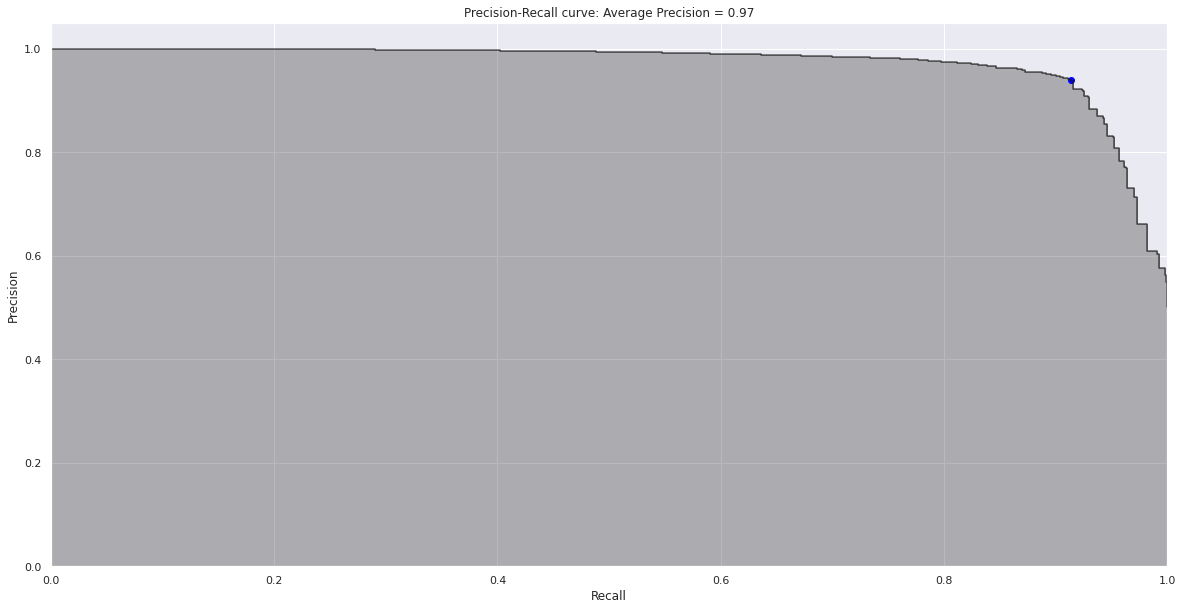

In [170]:
preds = pd.concat([y_train_res,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
corte = np.argmax(fscore)
print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))


plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

Optimal Threshold=0.516129


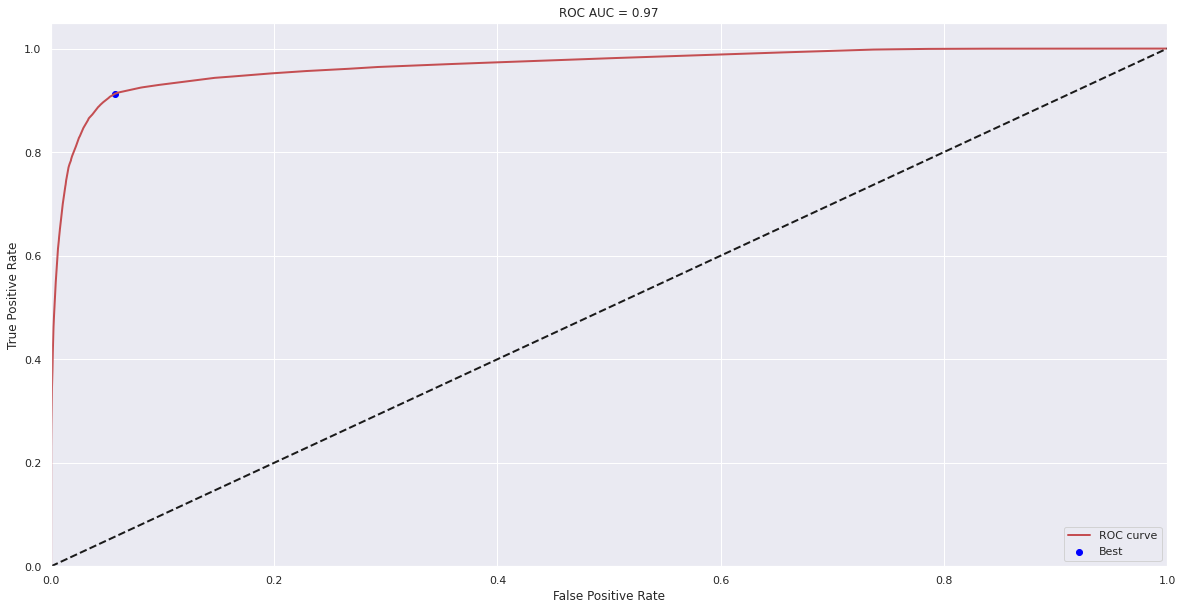

In [171]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

areaUnderROC = auc(fpr, tpr)

# To find the best threshold we can use Youden's statistic 
# J = Sensitivity + Specificity – 1
# https://en.wikipedia.org/wiki/Youden%27s_J_statistic

# But we have that Sensitivity is the True Positive Rate
# And then J = Sensitivity + (1 – FalsePositiveRate) – 1
# Then

J = tpr - fpr
optim = np.argmax(J)
best_thresh = thresholds[optim]
print('Optimal Threshold=%f' % (best_thresh))


plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# optimal point
plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')
#
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Decision tree performance over train set and test

In [370]:
df_dtc = pd.DataFrame({'dtc_proba': dtc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_dtc.loc[:, 'label_dtc'] = 1 * (df_dtc.loc[:, 'dtc_proba'] > .5) 
df_dtc.describe() 

,dtc_proba,true_class,label_dtc
count,87145.000000,87145.000000,87145.000000
mean,0.127729,0.000849,0.071020
std,0.184352,0.029128,0.256859
min,0.000000,0.000000,0.000000
25%,0.075272,0.000000,0.000000
50%,0.075272,0.000000,0.000000
75%,0.075272,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [371]:
df_dtc[df_dtc.true_class == 1].label_dtc.value_counts()

1    51
0    23
Name: label_dtc, dtype: int64

In [189]:
df_dtc[df_dtc.true_class == 0].label_dtc.value_counts()

0    80933
1     6138
Name: label_dtc, dtype: int64

In [228]:
list_metrics(y_train, dtc_k.predict(X_train[process_cols]))

Accuray: 0.9293017384818406
Recall score: 0.6891891891891891
Average_precision_score:  0.005943140837902709
Precision Score: 0.008240426563257392
F1_score: 0.016286124860290595

 ConfusionMatrix: 
 [[80933  6138]
 [   23    51]]


In [197]:
list_metrics(y_test, dtc_k.predict(X_test[process_cols]))

Accuray: 0.9285656911831642
Recall score: 0.71875
Average_precision_score:  0.006404747339168892
Precision Score: 0.008575689783743476
F1_score: 0.016949152542372885

 ConfusionMatrix: 
 [[34658  2659]
 [    9    23]]


## RANDOM FOREST

In [198]:
rfc_k = RandomForestClassifier(ccp_alpha=0.0001, class_weight='balanced', 
                               max_depth=8,min_samples_split = 15,
                               n_estimators=260, n_jobs=-1, oob_score=True,
                               random_state=2020)

In [199]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train_res.index,columns=[0,1])

In [200]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    rfc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, rfc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = rfc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossrfc = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('RFC Log Loss: ', loglossrfc) 
#Logistic Regression Log Loss:  0.5289955008268935

Training Log Loss:  0.15912834909894122
CV Log Loss:  0.1570223092941343
Training Log Loss:  0.15665697638590567
CV Log Loss:  0.15948960292824954
Training Log Loss:  0.1571094908768956
CV Log Loss:  0.1607531888717447
Training Log Loss:  0.15652084615851977
CV Log Loss:  0.15863826183079482
Training Log Loss:  0.1572426639501342
CV Log Loss:  0.15694194065701253
Training Log Loss:  0.15702147660802984
CV Log Loss:  0.15618503589359267
RFC Log Loss:  0.15817174171630735


### Random forest performance over resampled sets

In [201]:
def plotPerformance(y , preds, returnPreds = False):
    """
    y is a series, in notebook is y_train or a derived series made of the true labels
    preds are the prediction made by the classifier, in label form
    it can be the corresponding y_preds from train
    in notebook is predictionsBasedOnKFolds.loc[:,1] as taken from Chollet's book

    """
    preds = pd.concat([y, preds], axis=1)
    preds.columns = ['trueLabel', 'preds']
    precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['preds'])
    average_precision = average_precision_score(preds['trueLabel'],preds['preds'])
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    corte = np.argmax(fscore)
    print('Optimal Threshold=%f, F-Score=%.3f' % (thresholds[corte], fscore[corte]))

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
    plt.scatter(recall[corte], precision[corte], marker='o', color='blue', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['preds'])
    areaUnderROC = auc(fpr, tpr)
    J = tpr - fpr
    optim = np.argmax(J)
    best_cut = thresholds[optim]
    print('Optimal Threshold=%f' % (best_cut))

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    # optimal cut
    plt.scatter(fpr[optim], tpr[optim], marker='o', color='blue', label='Best')
    #
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

Optimal Threshold=0.587253, F-Score=0.951
Optimal Threshold=0.633443


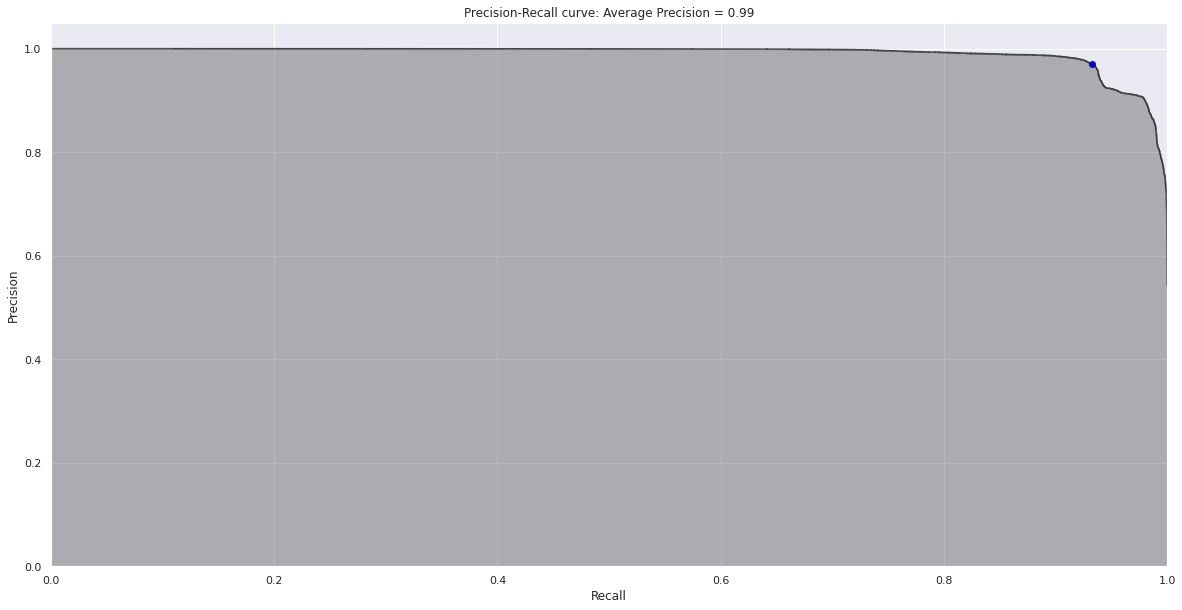

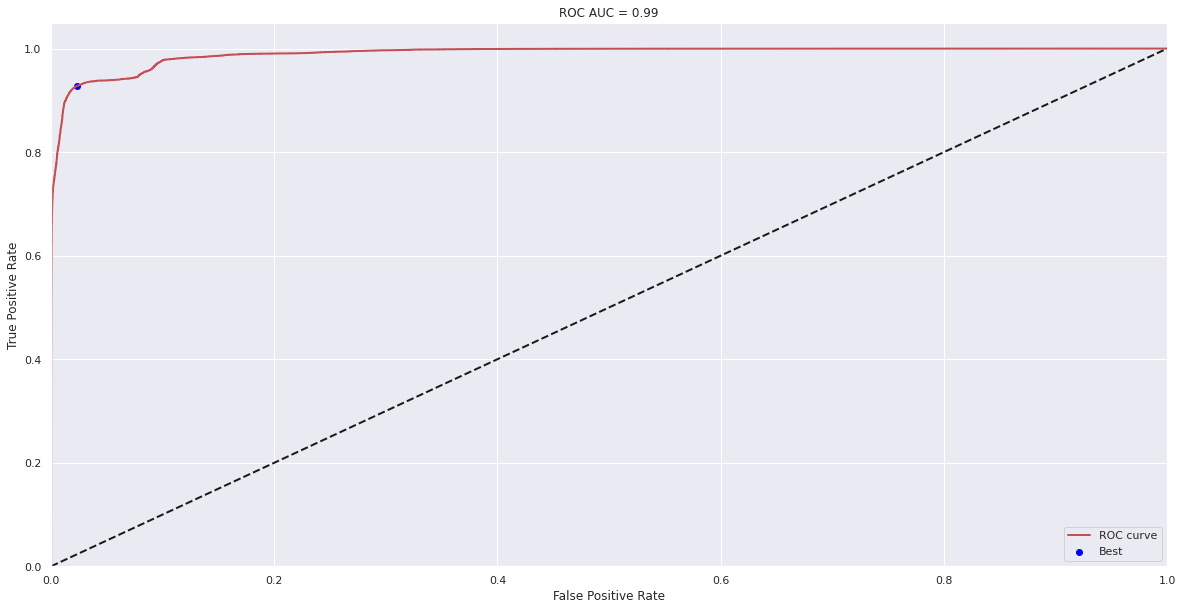

In [203]:
preds = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1],returnPreds=True)

### Random forest performance over train set and test

In [205]:
df_rfc = pd.DataFrame({'rfc_proba': rfc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_rfc.loc[:, 'label_rfc'] = 1 * (df_rfc.loc[:, 'rfc_proba'] > .5) 
df_rfc.describe() #

,rfc_proba,true_class,label_rfc
count,87145.000000,87145.000000,87145.000000
mean,0.113851,0.000849,0.037604
std,0.140153,0.029128,0.190238
min,0.011631,0.000000,0.000000
25%,0.043464,0.000000,0.000000
50%,0.067592,0.000000,0.000000
75%,0.115437,0.000000,0.000000
max,0.989510,1.000000,1.000000


In [385]:
df_rfc[df_rfc.true_class == 1].label_rfc.value_counts(normalize=True)

1    0.702703
0    0.297297
Name: label_rfc, dtype: float64

In [227]:
list_metrics(y_train, rfc_k.predict(X_train[process_cols]))

Accuray: 0.9627402604853978
Recall score: 0.7027027027027027
Average_precision_score:  0.01140306023622762
Precision Score: 0.015868172108635947
F1_score: 0.031035511787526116

 ConfusionMatrix: 
 [[83846  3225]
 [   22    52]]


In [208]:
list_metrics(y_test, rfc_k.predict(X_test[process_cols]))

Accuray: 0.9616321722134461
Recall score: 0.625
Average_precision_score:  0.008995825318099292
Precision Score: 0.013879250520471894
F1_score: 0.027155465037338764

 ConfusionMatrix: 
 [[35896  1421]
 [   12    20]]


## Gradient boosting classifier

In [209]:
gbc_k = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features=7, validation_fraction=0.1, 
                           n_estimators=250, n_iter_no_change=12,
                           random_state=2020, subsample=0.95)

In [210]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train_res.index,columns=[0,1])

In [211]:
for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:],X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index],y_train_res.iloc[cv_index]
    
    gbc_k.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, gbc_k.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = gbc_k.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossgbc = log_loss(y_train_res, predictionsBasedOnKFolds.loc[:,1]) 
#l1 y C=.4 Logistic Regression with interactions Log Loss:  0.47963111564766253
print('RFC Log Loss: ', loglossgbc) 
#Logistic Regression Log Loss:  0.5289955008268935

Training Log Loss:  0.32869738949580624
CV Log Loss:  0.32573457573760056
Training Log Loss:  0.3274257935334146
CV Log Loss:  0.3302932451738174
Training Log Loss:  0.327650344296417
CV Log Loss:  0.33046056457458317
Training Log Loss:  0.3277841869222503
CV Log Loss:  0.32920400029629887
Training Log Loss:  0.32840622259410385
CV Log Loss:  0.32657895707141793
Training Log Loss:  0.3283846193208663
CV Log Loss:  0.32680678305612504
RFC Log Loss:  0.32817970472756225


### Gradient Boosting performance over resampled sets

Optimal Threshold=0.581068, F-Score=0.923
Optimal Threshold=0.581068


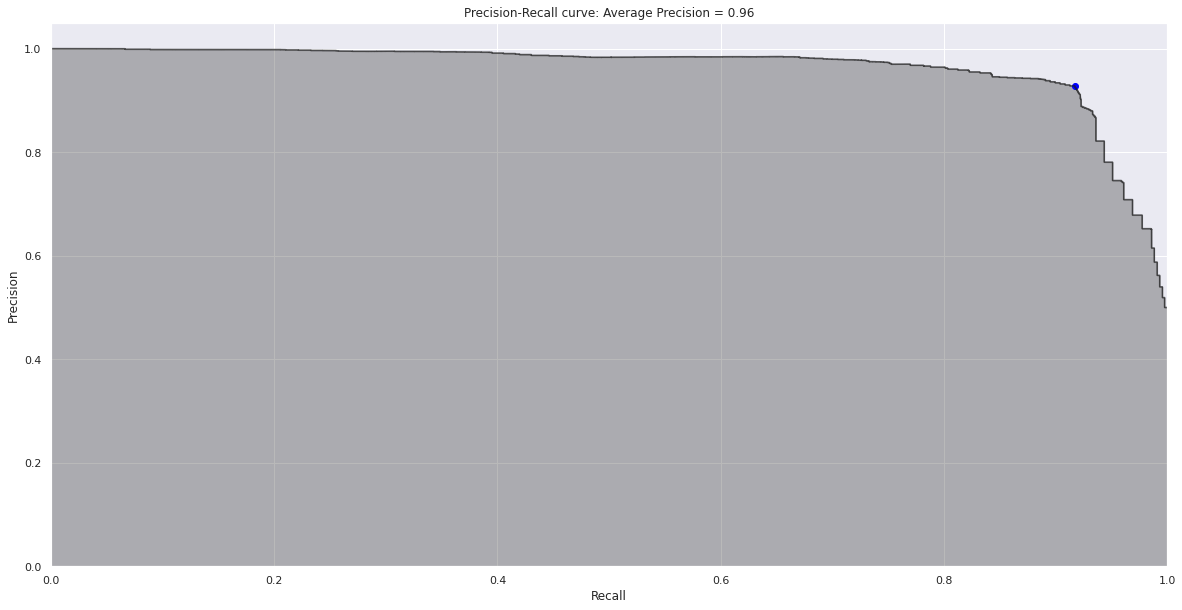

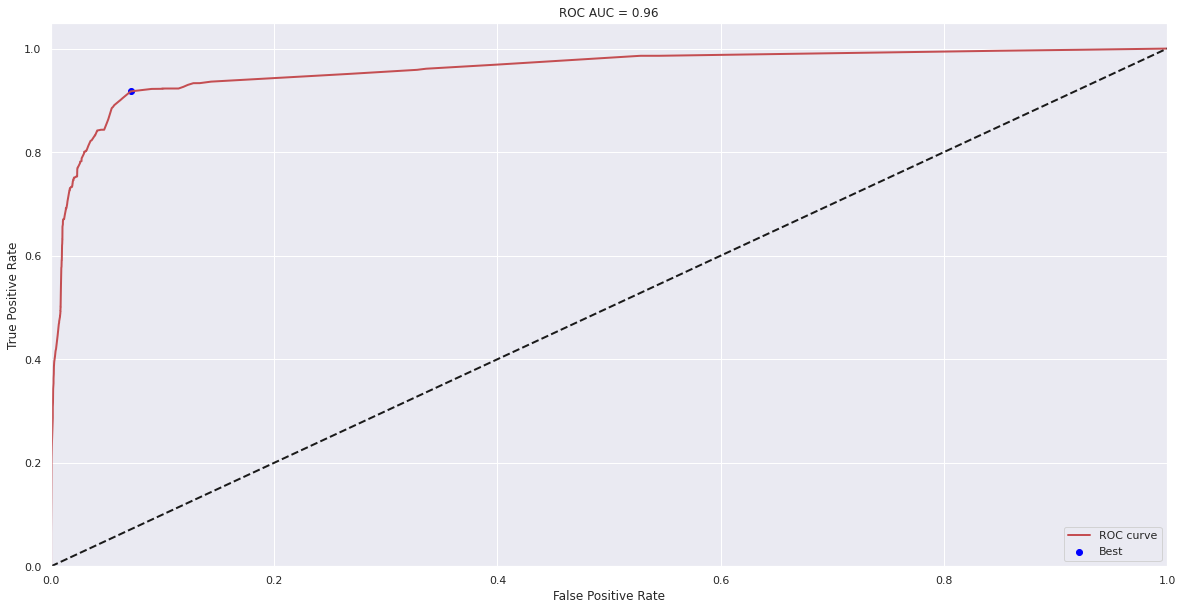

In [212]:
preds = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1],returnPreds=True)

### Gradient Boosting classifier performance over train set and test

In [223]:
df_gbc = pd.DataFrame({'gbc_proba': gbc_k.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_gbc.loc[:, 'label_gbc'] = 1 * (df_gbc.loc[:, 'gbc_proba'] > .5) 
df_gbc.describe() #

,gbc_proba,true_class,label_gbc
count,87145.000000,87145.000000,87145.000000
mean,0.250682,0.000849,0.094647
std,0.142887,0.029128,0.292728
min,0.196785,0.000000,0.000000
25%,0.196785,0.000000,0.000000
50%,0.208344,0.000000,0.000000
75%,0.208344,0.000000,0.000000
max,0.842784,1.000000,1.000000


In [224]:
df_gbc[df_gbc.true_class == 1].label_gbc.value_counts()

1    54
0    20
Name: label_gbc, dtype: int64

In [226]:
list_metrics(y_train, gbc_k.predict(X_train[process_cols]))

Accuray: 0.905743301394228
Recall score: 0.7297297297297297
Average_precision_score:  0.005007073528653029
Precision Score: 0.006547041707080504
F1_score: 0.012977649603460706

 ConfusionMatrix: 
 [[78877  8194]
 [   20    54]]


In [225]:
list_metrics(y_test, gbc_k.predict(X_test[process_cols]))

Accuray: 0.9065838442796327
Recall score: 0.8125
Average_precision_score:  0.006180880556212667
Precision Score: 0.007409518381305215
F1_score: 0.014685117198531489

 ConfusionMatrix: 
 [[33834  3483]
 [    6    26]]


# MODEL OPTIMIZATION: GRADIENT BOOSTING MACHINE HYPERPARAMETERS


The following steps represent one way to search for hyperparameters in a given range.

In [230]:
gbc_h = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features='auto', validation_fraction=0.1, 
                           random_state=2020, subsample=0.95)

In [241]:
pipe_gb = Pipeline([('classifier' , GradientBoostingClassifier(random_state=2020))])

param_grid_gb = [
    {'classifier' : [GradientBoostingClassifier(learning_rate=0.005, 
                           validation_fraction=0.1, 
                           random_state=2020, subsample=0.95 , n_iter_no_change=12,
                                            max_features="auto",  ccp_alpha= 0.0001
                                            #class_weight="balanced",
                                            )],
    'classifier__n_estimators' : list(range(200,301,20)),
    'classifier__max_depth' : list(range(4,9,1))
    } 
]

In [244]:
clf_gb = GridSearchCV(pipe_gb, param_grid = param_grid_gb, cv = 3, verbose=True, n_jobs=-1) #cambiar a 5

In [245]:
best_gb = clf_gb.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 25.4min finished


In [246]:
print(best_gb.best_estimator_.get_params()['classifier'])

GradientBoostingClassifier(ccp_alpha=0.0001, learning_rate=0.005, max_depth=8,
                           max_features='auto', n_estimators=300,
                           n_iter_no_change=12, random_state=2020,
                           subsample=0.95)


In [247]:
print('Accuracy en entrenamiento rf',clf_gb.score(X_train, y_train))
print('Accuracy en prueba rf',clf_gb.score(X_test, y_test))

Accuracy en entrenamiento rf 0.9632222158471513
Accuracy en prueba rf 0.9631315430131998


In [248]:
classes_gb = clf_gb.predict(X_test)
print(classification_report(classes_gb, y_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35964
           1       0.62      0.01      0.03      1385

    accuracy                           0.96     37349
   macro avg       0.79      0.51      0.50     37349
weighted avg       0.95      0.96      0.95     37349



We just found the best hyperparameters in a test range. Now we retrain the best model using k-fold cross validation.

In [250]:
gbc_h = GradientBoostingClassifier(ccp_alpha=0.0001, learning_rate=0.005, max_depth=8,
                           max_features='auto', n_estimators=300, 
                           n_iter_no_change=12, random_state=2020,
                           subsample=0.95)

In [38]:
#y_train_res = pd.DataFrame(y_train_res, columns=['y'])
#X_train_res = pd.DataFrame(X_train_res)

In [251]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_res.index,columns=[0,1])


for train_index, cv_index in k_fold.split(np.zeros(len(X_train_res)),
                                          y_train_res.y.ravel()):
    X_train_fold, X_cv_fold = X_train_res.iloc[train_index,:], X_train_res.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_res.iloc[train_index], y_train_res.iloc[cv_index]
    
    gbc_h.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,gbc_h.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = gbc_h.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossgb_h = log_loss(y_train_res,predictionsBasedOnKFolds.loc[:,1])
print('GBC Hyp Log Loss: ', loglossgb_h) # before Random Forest Log Loss:  0.15557334239967888

Training Log Loss:  0.2145962822474282
CV Log Loss:  0.2144824161403904
Training Log Loss:  0.21560035874682276
CV Log Loss:  0.21820397098342054
Training Log Loss:  0.2136571652167317
CV Log Loss:  0.21580486995450074
Training Log Loss:  0.2153754941159966
CV Log Loss:  0.21761500882113238
Training Log Loss:  0.2147627096340386
CV Log Loss:  0.21418821330459376
Training Log Loss:  0.21482258119578276
CV Log Loss:  0.21394393617395316
GBC Hyp Log Loss:  0.21570642140196697


Optimal Threshold=0.328741, F-Score=0.957
Optimal Threshold=0.329720


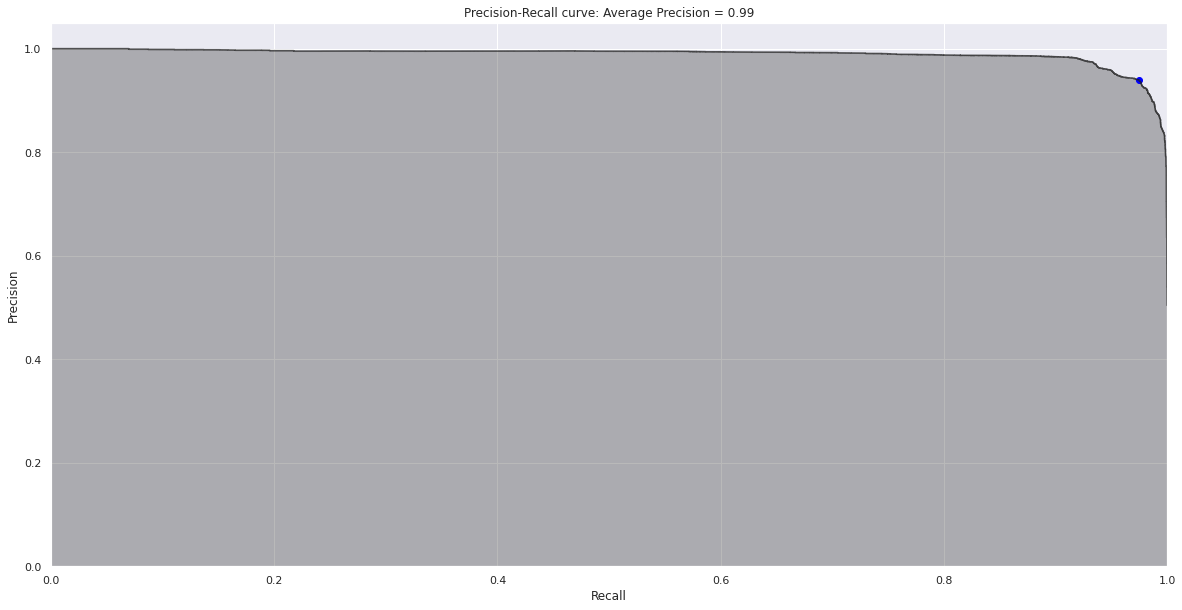

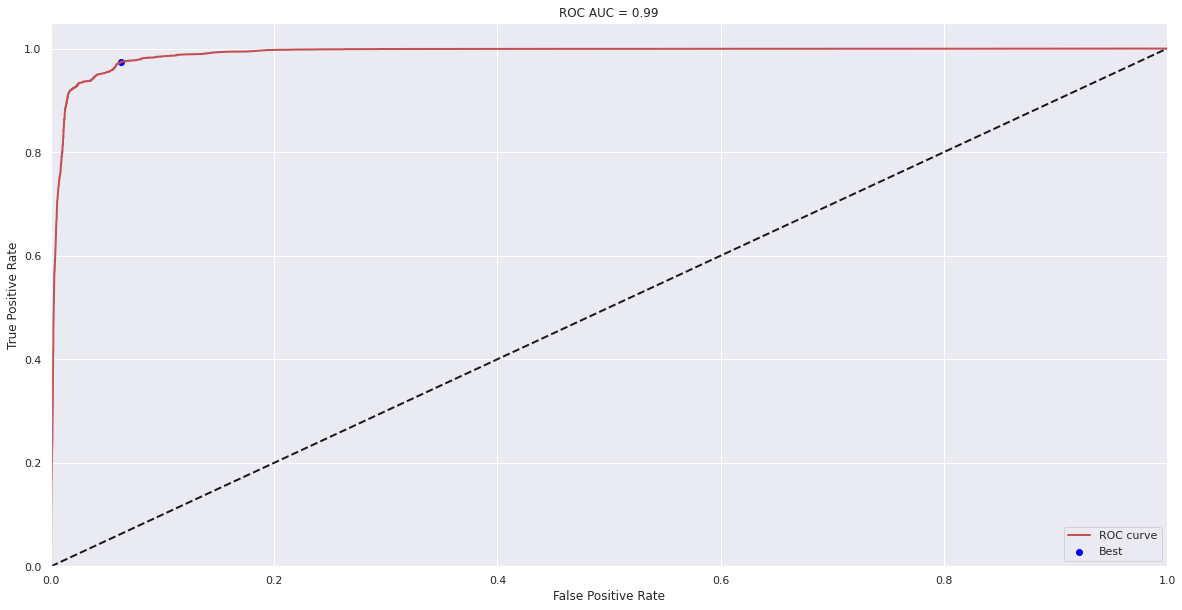

In [252]:
preds_gbc_h = plotPerformance(y_train_res,predictionsBasedOnKFolds.loc[:,1], returnPreds=True)

### GBM performance over train set and test

In [253]:
df_gbc_h = pd.DataFrame({'gbc_proba': gbc_h.predict_proba(X_train[process_cols])[:,1],
                        'true_class': y_train})
df_gbc_h.loc[:, 'label_gbc'] = 1 * (df_gbc_h.loc[:, 'gbc_proba'] > .5) 
df_gbc_h.describe()

,gbc_proba,true_class,label_gbc
count,87145.000000,87145.000000,87145.000000
mean,0.175861,0.000849,0.036824
std,0.124140,0.029128,0.188330
min,0.104984,0.000000,0.000000
25%,0.122303,0.000000,0.000000
50%,0.130501,0.000000,0.000000
75%,0.158156,0.000000,0.000000
max,0.881409,1.000000,1.000000


In [254]:
list_metrics(y_train, gbc_h.predict(X_train[process_cols]))

Accuray: 0.9635664696769751
Recall score: 0.7297297297297297
Average_precision_score:  0.012509155219281785
Precision Score: 0.016827672172016205
F1_score: 0.03289674078586659

 ConfusionMatrix: 
 [[83916  3155]
 [   20    54]]


In [255]:
list_metrics(y_test, gbc_h.predict(X_test[process_cols]))

Accuray: 0.9631315430131998
Recall score: 0.625
Average_precision_score:  0.009346564500927102
Precision Score: 0.01444043321299639
F1_score: 0.028228652081863093

 ConfusionMatrix: 
 [[35952  1365]
 [   12    20]]


# BENCHMARK AUTOENCODER

It's important to try a model with an architecture comming from neural networks, especially beacause we have found that nonlinear relations between attributes are present.

The simplest solution is a binary classifier, but we'll try a different also common approach: __an Autoencoder__.

I followed the example given here: https://blog.keras.io/building-autoencoders-in-keras.html

It was easier since we have no images!

In [256]:
# The first is just a benchmark for an autoencoder, to see what comes out with the failures dataset.
# Call API
model = Sequential()

# Componets:
# Linear activation function to input layer
# Hidden layer with 16 nodes, the same as the input layer
# Linear activation function to hidden layer
# Output layer with 8 nodes

model.add(Dense(units=48, activation='relu',input_dim=8))

model.add(Dense(units=8, activation='linear'))

In [257]:
# Compile the model, later we'll move these parameters

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [258]:
# Train on the oversampled sets with standarization.

num_epochs = 5
batch_size = 50


# Here is the autoencoder part of the model. Inside the fit method, we'll pass the train set as input x
# but also as target and calculate the reconstruction error.

history = model.fit(x=X_train_rlg, y=X_train_rlg,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_rlg, X_train_rlg),
                    verbose=1).history

Epoch 1/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.3436 - accuracy: 0.8574 - val_loss: 0.0047 - val_accuracy: 0.9106
Epoch 2/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0031 - accuracy: 0.9401 - val_loss: 0.0014 - val_accuracy: 0.9684
Epoch 3/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0029 - accuracy: 0.9552 - val_loss: 0.0013 - val_accuracy: 0.9765
Epoch 4/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0025 - accuracy: 0.9666 - val_loss: 4.1028e-04 - val_accuracy: 0.9760
Epoch 5/5
3483/3483 [==============================] - 5s 1ms/step - loss: 0.0019 - accuracy: 0.9694 - val_loss: 0.0087 - val_accuracy: 0.9727


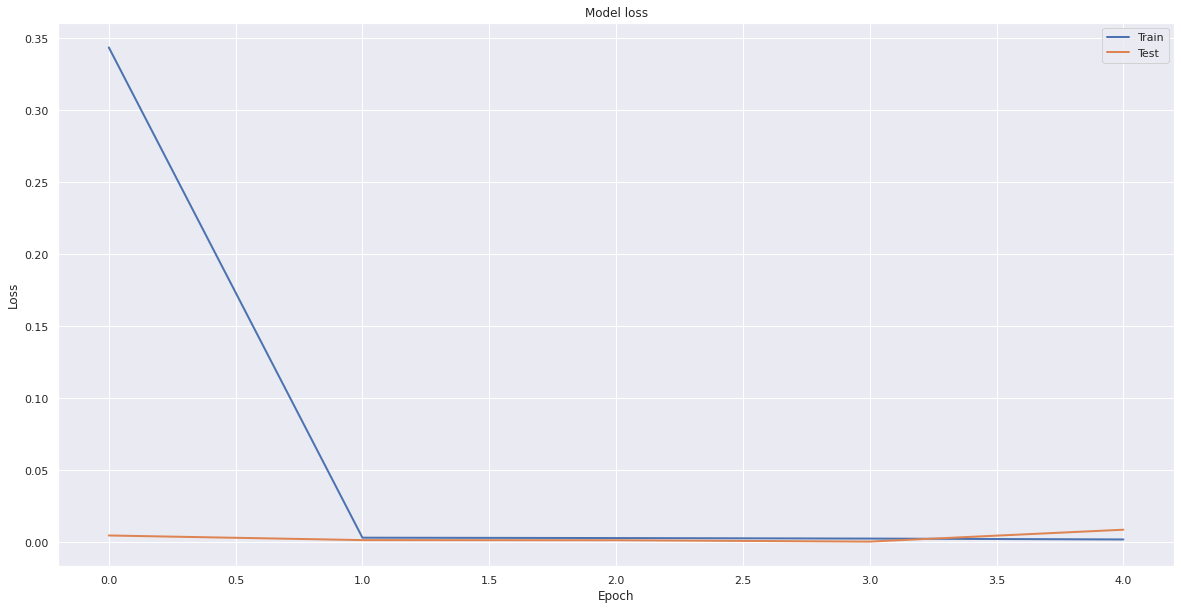

In [259]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [260]:
def is_failure_result(original_label, recons_label):
    recons_error = np.sum((np.array(original_label) - 
                   np.array(recons_label))**2, axis=1)
    recons_error = pd.Series(data=recons_error,index=original_label.index)
    recons_error = (recons_error-np.min(recons_error))/(np.max(recons_error)-np.min(recons_error))
    return recons_error

In [295]:
X_test_lg.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9
76947,0.077517,-0.072001,-0.058078,-0.072693,0.045795,-0.076160,-0.043522,-0.062762
57161,-0.911016,-0.072001,-0.058078,-0.072693,-0.016692,0.246424,-0.043522,-0.062762
98767,0.635352,0.170948,-0.058078,-0.072693,-0.204153,-0.194023,-0.043522,-0.062762
105826,-0.524346,-0.072001,-0.058078,-0.072693,-0.329127,-0.456060,-0.043522,-0.062762
99344,0.851777,2.111020,-0.058078,-0.072693,-0.016692,-1.734683,-0.043522,-0.062762


In [261]:
predictions = model.predict(X_test_lg, verbose=1)
failureScore = is_failure_result(X_test_lg, predictions)

1168/1168 [==============================] - 1s 608us/step


In [262]:
#predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(X_test_lg - predictions, 2), axis=1)
decoder_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
decoder_df.describe()

,Reconstruction_error,True_class
count,37349.000000,37349.000000
mean,0.014338,0.000857
std,1.157522,0.029259
min,0.000012,0.000000
25%,0.000106,0.000000
50%,0.000242,0.000000
75%,0.000631,0.000000
max,221.299058,1.000000


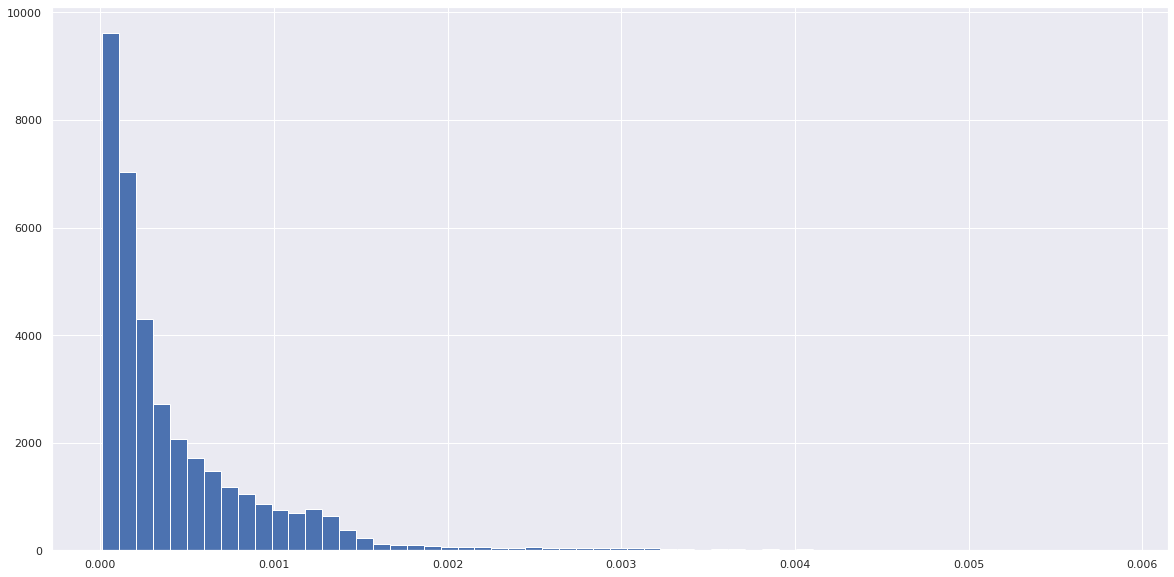

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
nonfailure_error_df = error_df[(error_df['True_class']== 0) & (error_df['Reconstruction_error'] < 0.006)]
_ = ax.hist(nonfailure_error_df.Reconstruction_error.values, bins=60)

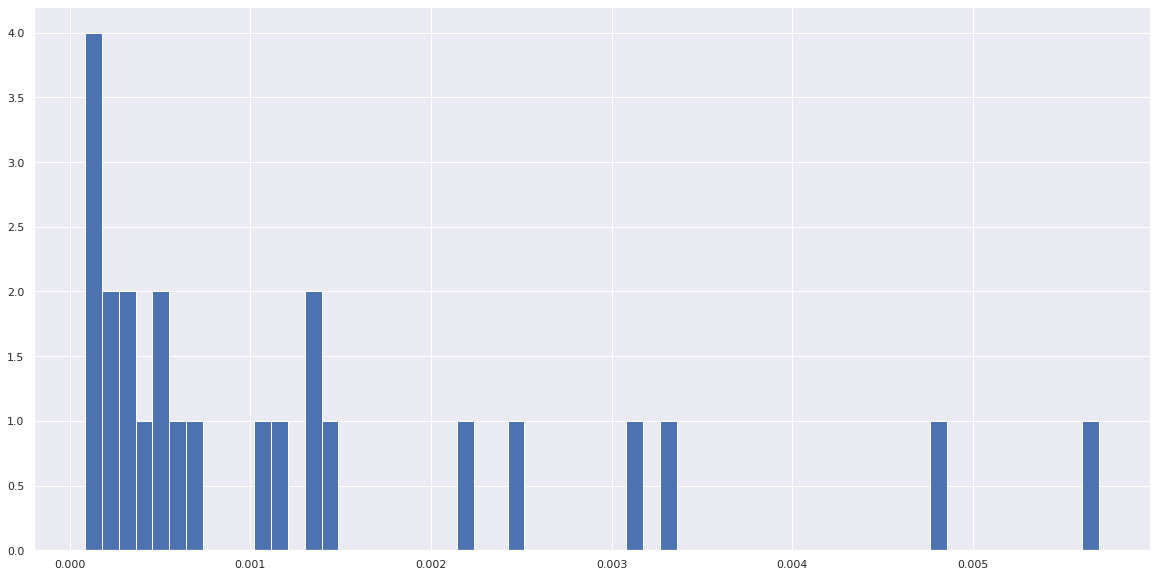

In [285]:
fig = plt.figure()
ax = fig.add_subplot(111)
failure_error_df = error_df[(error_df['True_class']== 1) & (error_df['Reconstruction_error'] < 0.006)]
_ = ax.hist(failure_error_df.Reconstruction_error.values, bins=60)

In [292]:
threshold = 0.0015

In [418]:
y_pred_aut = [1 if e > threshold else 0 for e in decoder_df.Reconstruction_error.values]
confusion_matrix(decoder_df.True_class, y_pred_aut)

array([[35307,  2010],
       [   18,    14]])

In [71]:
#preds = plotPerformance(y_test, failureScore, True)
#model.reset_states()

# SECOND AUTOENCODER, NOT FOR DETECTION...

We can see from the PR curve that it has no average precision at all. So, instead of going trough hyperparameter optimization and regularization and architecture selection, it seems to be a better choice to use internal the internal representation of the autoencoder and give it to te supervised random forest. 

This is an example of a semi-supervised learning approach.

In [ ]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

In [410]:
# !rm -rf ./logs/

In [411]:
model = Sequential()
model.add(Dense(units=24, activation='linear', 
                activity_regularizer=regularizers.l1(10e-5),
                input_dim=8, name='hidden_layer')) # here we name the layer for the representation
model.add(Dropout(0.01))
model.add(Dense(units=8, activation='linear'))

In [412]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [403]:
import datetime

In [413]:
num_epochs =  5
batch_size = 40

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



history = model.fit(x=X_train_rlg, y=X_train_rlg, epochs=num_epochs, batch_size=batch_size, shuffle=True,
                    validation_split=0.20, verbose=1,callbacks=[tensorboard_callback])

Epoch 1/5
3483/3483 [==============================] - 5s 2ms/step - loss: 0.5301 - accuracy: 0.8516 - val_loss: 0.0059 - val_accuracy: 0.9871
Epoch 2/5
3483/3483 [==============================] - 4s 1ms/step - loss: 0.0377 - accuracy: 0.9555 - val_loss: 0.0040 - val_accuracy: 0.9938
Epoch 3/5
3483/3483 [==============================] - 4s 1ms/step - loss: 0.0240 - accuracy: 0.9573 - val_loss: 0.0039 - val_accuracy: 0.9938
Epoch 4/5
3483/3483 [==============================] - 4s 1ms/step - loss: 0.0222 - accuracy: 0.9521 - val_loss: 0.0044 - val_accuracy: 0.9848
Epoch 5/5
3483/3483 [==============================] - 4s 1ms/step - loss: 0.0198 - accuracy: 0.9478 - val_loss: 0.0041 - val_accuracy: 0.9901


In [415]:
#%tensorboard --logdir logs/fit

In [303]:
predictions = model.predict(X_test_lg, verbose=1)
failures_p = is_failure_result(X_test_lg, predictions)

1168/1168 [==============================] - 1s 632us/step


In [313]:
from tensorflow.keras.models import load_model# save model to HDF5 
model.save("autoencoder_failure.h5")

# SEMI-SUPERVISED LEARNING: AUTOENCODER-GBM

In [304]:
layer_name = 'hidden_layer'

representation_layer  = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
representation_layer_train = representation_layer.predict(X_train_rlg)
representation_layer_test  = representation_layer.predict(X_test_lg)

In [312]:
representation_layer

In [314]:

representation_layer.save("representation_layer.h5")

In [305]:
representation_train_df = pd.DataFrame(data=representation_layer_train,index=X_train_rlg.index)
representation_test_df  = pd.DataFrame(data=representation_layer_test,index=X_test_lg.index)

In [306]:
X_train_aut = X_train_rlg.merge(representation_train_df, left_index=True,right_index=True)
X_test_aut  = X_test_lg.merge(representation_test_df, left_index=True,right_index=True)
y_train_aut = y_train_rlg.copy()

In [308]:
gbc_aut = GradientBoostingClassifier(learning_rate=0.005, 
                           max_features=7, validation_fraction=0.1, 
                           n_estimators=250, n_iter_no_change=12,
                           random_state=2020, subsample=0.95)

In [309]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train_aut.index,columns=[0,1])


for train_index, cv_index in k_fold.split(np.zeros(len(X_train_aut)),
                                          y_train_aut.y.ravel()):
    X_train_fold, X_cv_fold = X_train_aut.iloc[train_index,:], X_train_aut.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train_aut.iloc[train_index], y_train_aut.iloc[cv_index]
    
    gbc_aut.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold,gbc_aut.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = gbc_aut.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossgb_aut = log_loss(y_train_res,predictionsBasedOnKFolds.loc[:,1])
print('Autoencoder-GBM Log Loss: ', loglossgb_aut) # before Random Forest Log Loss:  0.15557334239967888

Training Log Loss:  0.3944893537081709
CV Log Loss:  0.39297817610811075
Training Log Loss:  0.39403873971273917
CV Log Loss:  0.39577983193824284
Training Log Loss:  0.39474113980609193
CV Log Loss:  0.3946954637148943
Training Log Loss:  0.39399037759642114
CV Log Loss:  0.3953188633345643
Training Log Loss:  0.393602304314488
CV Log Loss:  0.3930575794684103
Training Log Loss:  0.39365572044699343
CV Log Loss:  0.3939673906371206
Autoencoder-GBM Log Loss:  0.3942995599062471


In [310]:
pickle.dump(gbc_aut, open('gbc_aut.pkl', 'wb'))

Optimal Threshold=0.647943, F-Score=0.973
Optimal Threshold=0.650139


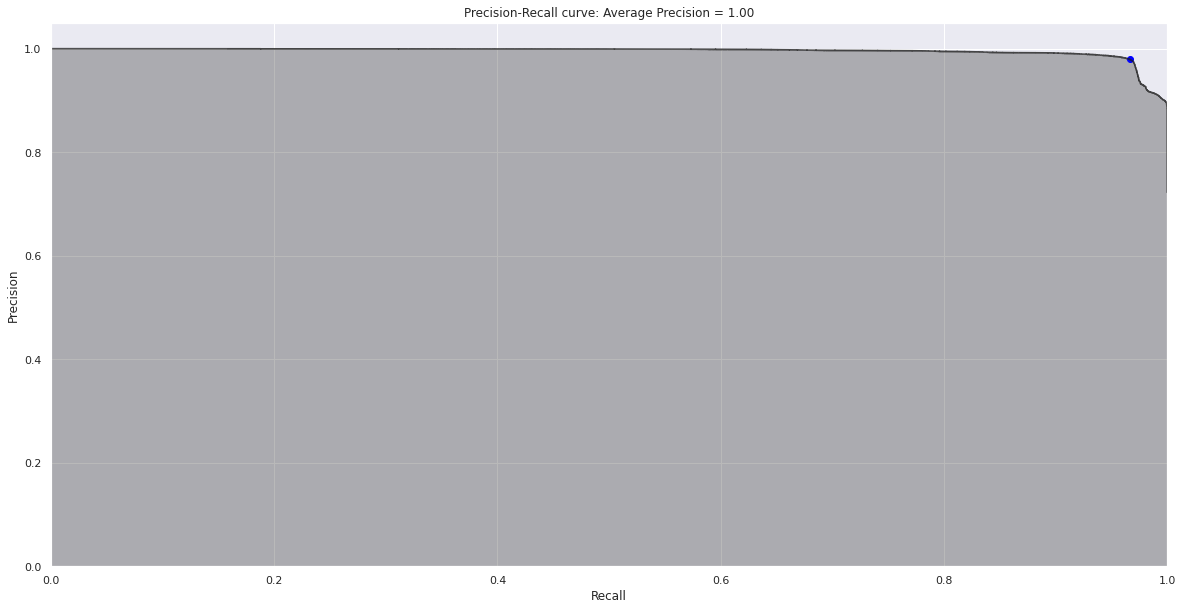

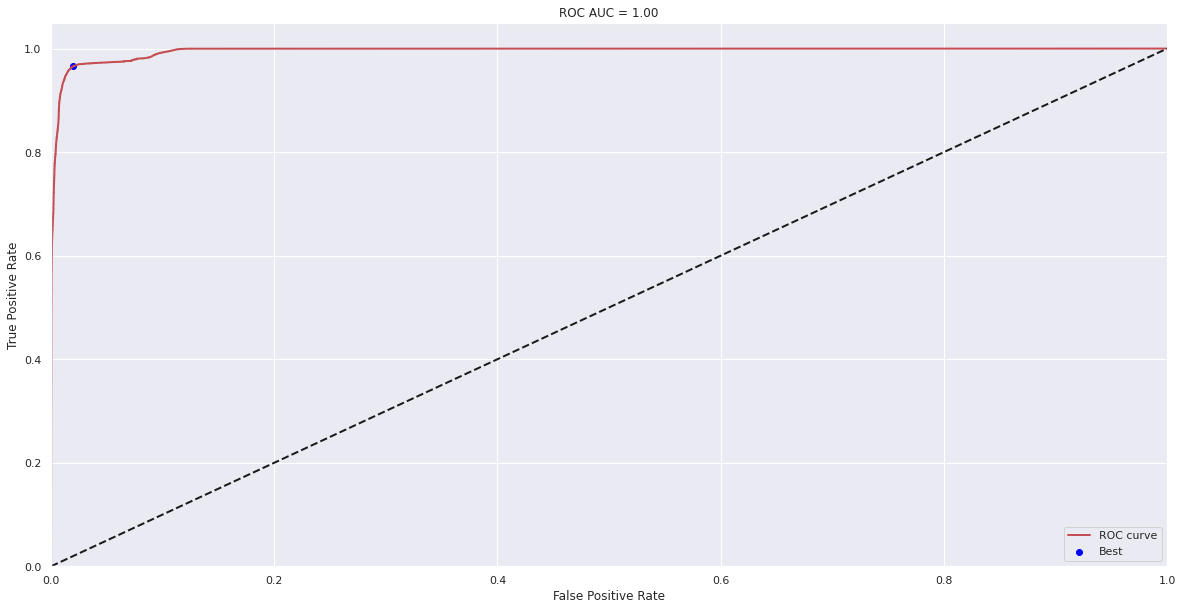

In [88]:
preds_aut = plotPerformance(y_train_aut, predictionsBasedOnKFolds.loc[:,1], True)
#Optimal Threshold=0.599890, F-Score=0.952
#Optimal Threshold=0.599890


# PIPELINE FOR EVALUATION

Now we have to build a pipeline to make the evaluation of the model on the full set and test set.

1. Load "eval_devices" is the copy of the original set with "process_cols" as the variables we used.
2. Then, we apply standarization.
3. A third step is to use de hidden layer as model to add the new features from the learning representation and merge them to eval_devices.
4. Last step is to apply the semi-supervised model.

In [49]:
#eval_devices.head()

In [317]:
process_cols

['attribute1',
 'attribute2',
 'attribute3',
 'attribute4',
 'attribute5',
 'attribute6',
 'attribute8',
 'attribute9']

In [321]:
eval_devicesSD = pipeline.fit_transform(eval_devices[process_cols]) 
# using the full set is not entirely correct (as an evaluation step), 
# but we need to evaluate on all the failures and, a point in our favour, we are not training, the models are alredy fitted.
eval_devicesSD = pd.DataFrame(data=eval_devicesSD, index=eval_devices.index)

In [322]:
eval_devicesSD.head()

,0,1,2,3,4,5,6,7
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375


In [316]:
rep_model = load_model("representation_layer.h5")

In [323]:
new_representation = rep_model.predict(eval_devicesSD)

In [324]:
new_representationDF = pd.DataFrame(data=new_representation,index=eval_devices.index)
X_aut = eval_devicesSD.merge(new_representationDF, left_index=True,right_index=True)
y = eval_devices.failure.copy()

In [50]:
#X_aut.head()

In [326]:
preds_semi = gbc_aut.predict_proba(X_aut)

In [352]:
eval_devices["predict_semi"] = gbc_aut.predict_proba(X_aut)[:,1]
eval_devices.loc[:, 'label_semi'] = 1 * (eval_devices.loc[:, 'predict_semi'] > .75)

In [353]:
eval_devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9,tag,predict_dtc,predict_rfc,predict_gbc,label_dtc,label_rfc,label_gbc,predict_semi,label_semi
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,2.0,0.103516,0.418365,0.816800,0,0,1,0.632300,0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,2.0,0.009302,0.066886,0.208154,0,0,0,0.556666,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,2.0,0.080413,0.087148,0.197101,0,0,0,0.738382,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,2.0,0.258679,0.049812,0.208154,0,0,0,0.554077,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,2.0,0.080413,0.125965,0.208154,0,0,0,0.765165,1


In [52]:
#eval_devices[eval_devices.failure==1].label_semi.value_counts(normalize=False)

In [355]:
eval_devices[eval_devices.failure==0].label_semi.value_counts(normalize=True)

0    0.794892
1    0.205108
Name: label_semi, dtype: float64

__On the test set:__

In [357]:
X_test_aut.head()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
76947,0.077517,-0.072001,-0.058078,-0.072693,0.045795,-0.076160,-0.043522,-0.062762,0.100681,0.00000,0.363725,0.331943,0.000000,0.668941,0.154811,0.307064,0.234133,0.00000,0.286226,0.208051,0.000000,0.242436,0.252064,0.196419,0.000000,0.231939,0.0,0.000000,0.000000,0.028860,0.000000,0.195366
57161,-0.911016,-0.072001,-0.058078,-0.072693,-0.016692,0.246424,-0.043522,-0.062762,0.189124,0.12186,0.567237,0.152880,0.000000,0.411754,0.000000,0.000000,0.487411,0.00000,0.266843,0.033805,0.126980,0.729191,0.535083,0.030779,0.025588,0.000000,0.0,0.000000,0.000000,0.000000,0.453377,0.145585
98767,0.635352,0.170948,-0.058078,-0.072693,-0.204153,-0.194023,-0.043522,-0.062762,0.170016,0.00000,0.195652,0.357540,0.193826,0.848451,0.184638,0.492482,0.000000,0.03494,0.105676,0.371036,0.000000,0.000000,0.095617,0.187712,0.000000,0.320637,0.0,0.000000,0.047037,0.118204,0.000000,0.245043
105826,-0.524346,-0.072001,-0.058078,-0.072693,-0.329127,-0.456060,-0.043522,-0.062762,0.096345,0.00000,0.606582,0.276983,0.000000,0.751458,0.399200,0.000000,0.293167,0.00000,0.142440,0.181294,0.328929,0.273752,0.336657,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.419656,0.354925
99344,0.851777,2.111020,-0.058078,-0.072693,-0.016692,-1.734683,-0.043522,-0.062762,0.825003,0.00000,0.055905,1.153270,0.662949,1.765052,1.098656,0.173898,0.000000,0.00000,0.143645,1.040022,0.246930,0.015192,0.000000,0.000000,0.000000,0.860509,0.0,0.095213,0.377805,0.000000,0.545907,1.621472


In [364]:
df_gbc_aut = pd.DataFrame({'agbc_proba': gbc_aut.predict_proba(X_test_aut)[:,1],
                        'true_class': y_test})
df_gbc_aut.loc[:, 'label_agbc'] = 1 * (df_gbc_aut.loc[:, 'agbc_proba'] > .75) 
df_gbc_aut.describe()

,agbc_proba,true_class,label_agbc
count,37349.000000,37349.000000,37349.000000
mean,0.712132,0.000857,0.208252
std,0.053740,0.029259,0.406063
min,0.433343,0.000000,0.000000
25%,0.697424,0.000000,0.000000
50%,0.729798,0.000000,0.000000
75%,0.746806,0.000000,0.000000
max,0.841717,1.000000,1.000000


In [365]:
y_test.value_counts()

0    37317
1       32
Name: failure, dtype: int64

In [366]:
df_gbc_aut[df_gbc_aut.true_class == 1].label_agbc.value_counts()

1    23
0     9
Name: label_agbc, dtype: int64

In [367]:
df_gbc_aut[df_gbc_aut.true_class == 0].label_agbc.value_counts()

0    29562
1     7755
Name: label_agbc, dtype: int64

# EVALUATION ON TEST

Conclusions can be taken from the test set. Also over the full set since all training was made on a set with over-sampling.

In [373]:
df_test = pd.DataFrame({'dtc_proba': dtc_k.predict_proba(X_test[process_cols])[:,1],
                       'gbc_proba': gbc_k.predict_proba(X_test[process_cols])[:,1],
                       'rfc_proba': rfc_k.predict_proba(X_test[process_cols])[:,1],
                       'gbh_proba': gbc_h.predict_proba(X_test[process_cols])[:,1],
                        'true_class': y_test})

df_test.loc[:, 'label_dtc'] = 1 * (df_test.loc[:, 'dtc_proba'] > .5) 

df_test.loc[:, 'label_gbc'] = 1 * (df_test.loc[:, 'gbc_proba'] > .58) 
#
df_test.loc[:, 'label_rfc'] = 1 * (df_test.loc[:, 'rfc_proba'] > .58) 
#
df_test.loc[:, 'label_gbh'] = 1 * (df_test.loc[:, 'gbh_proba'] > .5) 

In [374]:
df_test.head()

,dtc_proba,gbc_proba,rfc_proba,gbh_proba,true_class,label_dtc,label_gbc,label_rfc,label_gbh
76947,0.218841,0.196785,0.095524,0.128682,0,0,0,0,0
57161,0.218841,0.208344,0.099246,0.147826,0,0,0,0,0
98767,0.727085,0.719992,0.485727,0.261132,0,1,1,0,0
105826,0.075272,0.196785,0.073331,0.140015,0,0,0,0,0
99344,0.531749,0.719992,0.350970,0.188140,0,1,1,0,0


In [398]:
df_test[df_test.true_class == 1].label_dtc.value_counts(normalize=True)

1    0.71875
0    0.28125
Name: label_dtc, dtype: float64

In [397]:
df_test[df_test.true_class == 1].label_gbc.value_counts(normalize=True)

1    0.75
0    0.25
Name: label_gbc, dtype: float64

In [396]:
df_test[df_test.true_class == 1].label_rfc.value_counts(normalize=True)

1    0.5625
0    0.4375
Name: label_rfc, dtype: float64

In [395]:
df_test[df_test.true_class == 1].label_gbh.value_counts(normalize=True)

1    0.625
0    0.375
Name: label_gbh, dtype: float64

In [394]:
df_gbc_aut[df_gbc_aut.true_class == 0].label_agbc.value_counts(normalize=True)

0    0.792186
1    0.207814
Name: label_agbc, dtype: float64

In [ ]:
# precision is also good for 

# __CONCLUSIONS__

1. WE HAVE VERY NICE BENCHMARK, ALL THE MODELS ARE GOOD FOR DETECTING AUTOMATICALY MORE THAN 56% OF FAILURES ON TEST. THE BEST MODEL CATCH 75% OF FAILURES.

2. ON THE FALSE POSITIVE SIDE, WE GO FROM 3% UP TO 20%. NOT A VERY BALANCED PERFORMANCE, BUT WE CAN DO BETTER WITH MORE TIME.

3. THE BEST MODEL IS THE __GRADIENT BOOSTING MACHINE__, WITH __75%__ DETECTIONS AND ONLY __7%__ FALSE POSITIVES.

4. WE TRIED A SEMI-SUPERVISED LEARNING APPROACH WITH VERY GOOD RESULTS ON DETECTION, BUT NO SO GOOD ON FALSE POSITIVES, IT SEND 14% MORE DEVICES TO MAINTENANCE. THIS IS NOT SUCH A BAD MODEL, BUT IT WAS NOT TUNNED SO MUCH AND WE CAN TRY A BETTER APPROACH TO REDUCE OVERFITTING AND PRESENT A MORE BALANCED APPROACH.

5. AS A PREVENTIVE TOOL, THERE IS THE NEED TO UNDERSTAND WHY 20% OF DEVICES WERE MARKED AS POTENTIAL RISKS OF FAILURE. THE AUTOENCODER-GBM OR THE GBM MODELS MAY HAVE DETECTED PATTERNS IN DATA THAT POINT TO A RELATION HIGHLY NON TRIVIAL THAT WE NEED TO UNDERSTANG.

6. AS FOLLOWING STEPS WE CAN TRY AN INTERPRETATION TOOL SUCH AS SHAP OR LIME TO BEGIN ANSWERING THESE QUESTIONS: 

    ARE FALSE POSITIVES THE SAME DEVICE? 
    
    HOW MANY?
    
    DID THEY FAIL LATER IN TIME?

7. PREDICTIVE MAINTENANCE IS A VERY DYNAMIC FIELD, WE CANNOT RELY ON THESE MODEL FOR TOO LONG. RE-TRAINING HAS TO BE ESTABLISHED, FOR EXAMPLE, BASED ON THE DISTRIBUTION OF THE ATTRIBUTES AT THE DAY OF TRAINING. A STATISTICAL TEST CAN BE PROGRAMMED EACH WEEK TO CHECK FOR CHANGES.

8. AS A BUSINESS PROPOSITION: I WOULD ASK TO THE CUSTOMER FOR THE MEANING OF THE ATTRIBUTES AND SCHEDULE WORK MEETINGS WITH DATA OWNERS AND PRODUCT OWNERS IN THE PROYECT TO UNDERSTAND MORE ABOUT THE BUSINESS NEEDS AND COSTS, BUT MORE IMPORTANT TO MEASURE REAL VALUE, PERHAPS THE CUSTOMER DETECTS ONLY 50% FAILURE WITH LITTLE TIME TO REACT, ETC.

# APPENDIX: RESULTS ON TEST SET

Here are the results on test sets given by k-fold validation.

In [117]:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = logReg.predict_proba(X_test_lg)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)

In [118]:
logLossTestSetLogisticRegression

0.5326994087488605

In [120]:
# X_test_lg2
preds_Test_lg_int = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
preds_Test_lg_int.loc[:,'prediction'] = logReg_int.predict_proba(X_test_lg2)[:,1]
logLoss_lg_int = log_loss(y_test, preds_Test_lg_int)

In [121]:
logLoss_lg_int

0.5090951233391061

In [144]:
predictionsTestSetRandomForests = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = rfc.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = log_loss(y_test, predictionsTestSetRandomForests)

In [145]:
logLossTestSetRandomForests

0.14599863080563444

# BIBLIOGRAPHY

__A. Géron, "Hands-on machine learning with scikit-learn, keras and tensorflow", 2nd edition.__

__Bowyer, et al., 2002, SMOTE: Synthetic Minority Over-sampling Technique, 
 Journal of Artificial Intelligence Research 16 (2002) 321–357 
 (https://arxiv.org/pdf/1106.1813.pdf, accessed on July 2020).__

__F. Chollet, "Deep Learning with python", Manning, 2018.__

__"Building Autoencoders in Keras" https://blog.keras.io/building-autoencoders-in-keras.html__